In [ ]:
import os
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
from itertools import product, combinations
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.cluster import KMeans

from Bio.Seq import Seq
from optimization.src.oracle import *
from optimization.src.encoding_utils import *
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

font = {'family' : 'arial',
        'size'   : 16}
mpl.rc('font', **font)
mpl.rc('lines', linewidth=2)
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2

labels = ['A', 'C', 'G', 'T', 'AG', 'CT', 'AC', 'GT', 'GC', 'AT', 'ACT', 'GCT', 'ACG', 'AGT', 'ACGT']
labels2 = ['A', 'C', 'G', 'T', 'R', 'Y', 'M', 'K', 'S', 'W', 'H', 'B', 'V', 'D', 'N']
labels4 = ['A', 'C', 'G', 'T', 'AG  (R)', 'CT (Y)', 'AC (M)', 'GT (K)', 'GC (S)', 'AT (W)', 'ACT (H)', 'GCT (B)', 'ACG (V)', 'AGT (D)', 'ACGT (N)']

labels3 = []
for i in range(12):
    labels3 += [str(i) + 'A', str(i) + 'C', str(i) + 'G', str(i) + 'T']

### For processing each individual trial

In [238]:
name = 'simple_stochastic'
results = np.load('dclo/saved/' + name + '/results.npy', allow_pickle=True)
means = results.item()['means']
vars = results.item()['vars']
Xts = results.item()['Xts'].astype(int)
final_means = means[-1, :, :]
final_vars = vars[-1, :, :]
initial_encodings = Xts[0, :, :]
final_encodings = Xts[-1, :, :]

# AA_library_sizes, unique_indices, final_AA_encodings, unique_encodings, unique_AA_encodings = get_AA_encodings(initial_encodings)
AA_library_sizes, unique_indices, final_AA_encodings, unique_encodings, unique_AA_encodings = get_AA_encodings(final_encodings)

(199, 48, 1)


In [152]:
name = 'swiftlib'
final_encodings = np.zeros((31, 48, 1))
max10000 = ["DYANNSGSADNS", "NHCNNSGGADNS", "VNCNNSGGADNS", "VWSNNSGGADNS", "NNCNDSGGADNS", "VHCNNSGGANNS", "VHSNNSGGANNC", "DYSNNSGGADNS", "VHANNSGGANNS", "NBCNNSGGADNS"]
max40000 = ["NNSNNSGGANNS", "NHSNNSGSADNS", "NNSNDSGSADNS", "VNSNNSGSADNS", "VHSNNSGSANNS", "NNSDNSGSADNS", "DNSNNSGSADNS", "NDSNNSGSADNS", "NHSNDSGSANNS", "NNSNNSGSANNC"]
max160000 = ["NNSNNSKSCNNS", "NNSNNSRSCNNS", "NNSNNSKSCDNS", "NHSNNSKSCNNS", "NNSNDSKSCNNS", "VNSNNSKSCNNS", "NNSNNSGSANNS", "NNSNNSRSCDNS", "NNMNNSKSCNNS", "NNSDNSKSCNNS"]
template_list = max10000 + max40000 + max160000 + ["NNKNNKNNKNNK"]

for i, encoding in enumerate(template_list):
    final_encodings[i, :, :] = seq2encoding(encoding).T

final_encodings2 = np.copy(final_encodings)
AA_library_sizes, unique_indices, final_AA_encodings, unique_encodings, unique_AA_encodings = get_AA_encodings(final_encodings)
unique_encodings = final_encodings2
unique_indices = np.arange(31)

(31, 48, 1)


In [239]:
df = pd.DataFrame(index = unique_indices)
df['Template1'] = [encoding2seq(encoding) for encoding in unique_encodings]
df['Library Size'] = [get_library_size(encoding) for encoding in unique_encodings]
df['AA Library Size'] = np.array(AA_library_sizes)[unique_indices]

In [157]:
with open('/home/jyang4/repos/StARDUST/dclo/saved/' + name + '/' + name + '.json', 'r') as f:
    config = json.load(f)

oracle = Oracle(config['data_config'], config['opt_config'], verbose = True)

fitness_df = pd.read_csv('/home/jyang4/repos/StARDUST/data/GB1/fitness.csv')
fitness_df['fit'] = fitness_df['fit']/np.max(fitness_df['fit'])
dictionary = dict(zip(fitness_df['Combo'], fitness_df['fit']))

triad_df = pd.read_csv('/home/jyang4/repos/StARDUST/data/GB1/GB1_all_triad.csv')
triad_df['ranked_zs'] = triad_df['Triad Score'].rank(ascending=False)/len(triad_df)
triad_dictionary = dict(zip(triad_df['Combo'], triad_df['ranked_zs']))

# triad_df = pd.read_csv('/home/jyang4/repos/StARDUST/data/tm9d8s/tm9d8s_all_evmutation.csv')
# triad_df['ranked_zs'] = triad_df['EVMutation Rank'].rank(ascending=False)/len(triad_df)
# triad_dictionary = dict(zip(triad_df['Combo'], triad_df['ranked_zs']))

final_encodings = unique_encodings

n_solutions = len(final_encodings)
results_maxes = np.zeros((n_solutions, 100))
results_means = np.zeros((n_solutions, 100))
top05 = np.zeros((n_solutions, 100))
weighted_simple_exp1 = np.zeros((n_solutions, 100))

weighted_simple = []
unweighted = []

top25 = []
unique = []

for i in range(n_solutions):
    #best_encoding = seq2encoding('TACNBCNNSAGC').reshape(1, final_encodings.shape[1], final_encodings.shape[2])
    #TACNNSNNSDCA
    #TWCDNSNNSASC

    #max 400 libraries:
    #TACNBCNNSAGC
    
    best_encoding = final_encodings[i, :, :].reshape(1, final_encodings.shape[1], final_encodings.shape[2])
    # oracle.aas2zs(oracle.sample(best_encoding), n_samples=384, seed=42 )

    means, vars, seqs = oracle.predict(best_encoding)

    #pooled = seqs.reshape((100, -1))
    # pooled = seqs.reshape((1, -1))
    # pooled_df = pd.DataFrame(pooled.T)

    # #best_df = pd.DataFrame(seqs[65,:,:])

    # best_df2 = pd.DataFrame(pooled_df[0])
    # best_df2.columns = ['Combo']
    
    # merged = best_df2.merge(fitness_df[['fit', 'Combo']], left_on = 'Combo', right_on='Combo', how='left')
    # all_fitnesses = merged['fit'].values
    
    #need to change this for the new runs with better values

    #need to fix this
    weighted_simple.append(means[0,0])

    unweighted.append(means[0,1])
    top25.append(means[0,3])
    unique.append(means[0,4])
    
    all_fitnesses = np.vectorize(dictionary.get)(seqs)
    all_fitnesses = np.array(all_fitnesses, dtype=np.float64)
    all_fitnesses = all_fitnesses.reshape((100, 384))

    all_triads = np.vectorize(triad_dictionary.get)(seqs)
    all_triads = np.array(all_triads, dtype=np.float64)
    all_triads = all_triads.reshape((100, 384))

    for j, row in enumerate(all_fitnesses):
        row = np.unique(row)
        results_maxes[i, j] = np.nanmax(row)
        results_means[i, j] = np.nansum(row)/384 #this mean is deflated because not all fitness values are present in the training set
    
    for j, row in enumerate(all_triads):
        row = np.unique(row)
        top05[i, j] = np.nansum(row > 0.95)
        weighted_simple_exp1[i, j] = np.nansum(row)

For calculating the true distribution

In [240]:
fitness_df = pd.read_csv('/home/jyang4/repos/StARDUST/data/GB1/fitness.csv')
fitness_df['fit'] = fitness_df['fit']/np.max(fitness_df['fit'])
fitness_df['ranked_fit'] = fitness_df['fit'].rank(ascending=True)/len(fitness_df)
dictionary = dict(zip(fitness_df['Combo'], zip(fitness_df['fit'], fitness_df['ranked_fit'])))

triad_df = pd.read_csv('/home/jyang4/repos/StARDUST/data/GB1/GB1_all_triad.csv')
triad_df['ranked_zs'] = triad_df['Triad Score'].rank(ascending=False)/len(triad_df)
triad_dictionary = dict(zip(triad_df['Combo'], triad_df['ranked_zs']))

triad_means = []
fitness_means = []
fitness_rank_means = []
all_results = np.zeros((len(unique_AA_encodings), 21**4, 4)) #four columns, 3 are for weights, 1 is for the frequency

for i, AA_encoding in enumerate(unique_AA_encodings):
    AA_encoding = AA_encoding.reshape((4, 21))

    all_freqs = list(product(AA_encoding[0], AA_encoding[1], AA_encoding[2], AA_encoding[3]))
    all_combos = list(product(ALL_AAS, ALL_AAS, ALL_AAS, ALL_AAS))
    all_combos = [''.join(combo) for combo in all_combos]

    total_freqs = [np.prod(freqs) for freqs in all_freqs]
    total_triad_sum = 0
    total_fitness_sum = 0
    total_fitness_rank_sum = 0
    total_freq = 0

    for j, (freq, combo) in enumerate(zip(total_freqs, all_combos)):
        if freq != 0 and '*' not in combo:
            all_results[i,j,0] = triad_dictionary[combo] 
            if combo in dictionary:
                all_results[i,j,1] = dictionary[combo][0] 
                all_results[i,j,2] = dictionary[combo][1] 
                all_results[i,j,3] = freq

    # triad_means.append(total_triad_sum/8916100448256) #1728 to the power of 4
    # fitness_means.append(total_fitness_sum/total_freq)
    # fitness_rank_means.append(total_fitness_rank_sum/total_freq)


In [242]:
triad_means = np.sum(all_results[:,:,0] * all_results[:,:,3], axis = 1)/8916100448256 #1728 to the power of 
total_freqs = np.sum(all_results[:,:,3], axis = 1)

fitness_means = np.sum(all_results[:,:,1] * all_results[:,:,3], axis = 1)/total_freqs
fitness_rank_means = np.sum(all_results[:,:,2] * all_results[:,:,3], axis = 1)/total_freqs

<AxesSubplot:ylabel='Percent'>

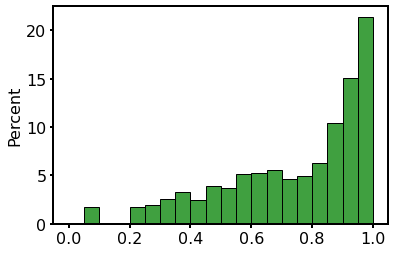

In [253]:
sns.histplot(x=all_results[0][:,2], weights=all_results[0][:,3], binwidth = 0.05, color='g',stat='percent')

<AxesSubplot:ylabel='Percent'>

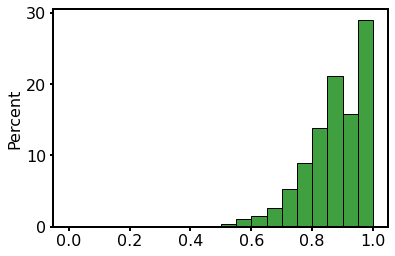

In [250]:
sns.histplot(x=all_results[0][:,0], weights=all_results[0][:,3], binwidth = 0.05, color='g',stat='percent')

<AxesSubplot:ylabel='Count'>

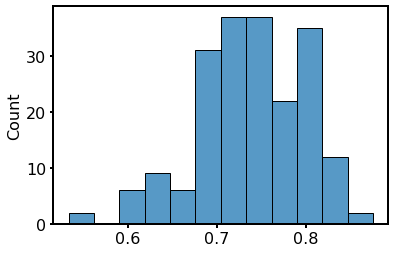

In [244]:
sns.histplot(fitness_rank_means)

<AxesSubplot:ylabel='Count'>

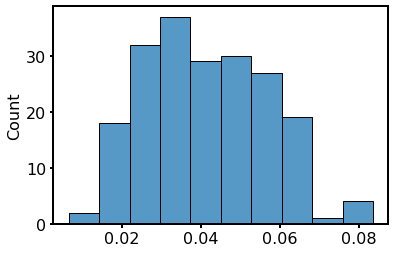

In [245]:
sns.histplot(fitness_means)

<AxesSubplot:ylabel='Count'>

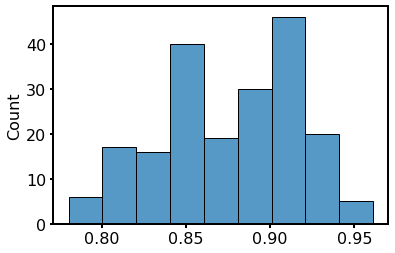

In [246]:
sns.histplot(triad_means)

In [97]:
weighted_simple_exp1_flat = np.mean(weighted_simple_exp1, axis = 1)
results_means_flat = np.median(results_means, axis = 1)
results_maxes_flat = np.median(results_maxes, axis = 1)
top05_flat = np.mean(top05, axis = 1)

#skip weighted full for now
columns = ['Weighted Simple', 'Weighted Simple exp1', 'frac_unique', 'frac_top25', 'frac_top5', 'Sampled Median Mean', 'Sampled Median Max']
for column, metric in zip(columns, [weighted_simple, weighted_simple_exp1_flat/384, np.array(unique)/384, np.array(top25)/384, np.array(top05_flat)/384, results_means_flat, results_maxes_flat]):
    df[column] = metric
    # print(np.mean(metric))
    # print(np.std(metric))
    # print('')

In [156]:
#if full coverage is available
results = np.load('dclo/saved/coverage_' + name + '/results.npy', allow_pickle=True)
means = results.item()['means']
vars = results.item()['vars']
Xts = results.item()['Xts'].astype(int)
final_means = means[-1, :, :]
final_vars = vars[-1, :, :]
weighted_full = final_means[:,0][unique_indices]
unweighted_full = final_means[:,1][unique_indices]
df['Weighted Full'] = weighted_full
df['Unweighted Full'] = unweighted_full
df['Weighted Full exp1'] = weighted_full

#comment this out if it was already exp1
results = np.load('dclo/saved/coverage_' + name + '_old/results.npy', allow_pickle=True)
means = results.item()['means']
vars = results.item()['vars']
Xts = results.item()['Xts'].astype(int)
final_means = means[-1, :, :]
final_vars = vars[-1, :, :]
weighted_full = final_means[:,0][unique_indices]
df['Weighted Full exp1'] = weighted_full

In [78]:
#if mlde results are available
results = np.load('/home/jyang4/repos/StARDUST/MLDE_lite/saved/boosting_' + name + '/mlde_results.npy', allow_pickle=True)

maxes = results.item()['maxes']
means = results.item()['means']
ndcgs = results.item()['ndcgs']
top_seqs = results.item()['top_seqs']
labelled = results.item()['labelled']
unique = results.item()['unique']

maxes2 = maxes.reshape(maxes.shape[3], maxes.shape[4]).T
means2 = means.reshape(means.shape[3], means.shape[4]).T
ndcgs2 = ndcgs.reshape(ndcgs.shape[3], ndcgs.shape[4]).T
unique2 = unique.reshape(unique.shape[3], unique.shape[4]).T

all_maxes_medians = np.median(maxes2, axis = 0).reshape(1, -1)
all_means_medians = np.median(means2, axis = 0).reshape(1, -1)
df['Boosting Median Max'] = all_maxes_medians.T[unique_indices]
df['Boosting Median Mean'] = all_means_medians.T[unique_indices]

In [157]:
df

,Template1,Library Size,AA Library Size,Weighted Full,Unweighted Full,Weighted Full exp1
32,TACVTRNNBNNB,13824,1764,4.526177,29.145838,20.347077
4,TACVTKNNBNNY,9216,1260,4.531717,28.763127,20.166108
13,TACDTRNNBDNS,6912,1512,4.487753,27.997546,19.756871
35,TAYDTRNNTNNC,3072,900,4.500777,28.374413,19.942175
40,TAYVTBNNBNNB,41472,1764,4.491941,28.876535,20.229254
...,...,...,...,...,...,...
44,NNYNBBDTNAGY,27648,975,4.160462,28.025224,19.469296
64,NNYDBSDTDAGC,5184,900,4.153369,27.638267,19.234928
60,NNYDBKNTBTCT,6912,900,4.112459,27.395734,19.189983
184,NHYDTRNNBTCA,6912,1008,4.273786,27.680160,19.517772


In [168]:
df.to_csv(name + '_lib_results.csv')
#df.to_csv('test.csv')

### Combining all of the results

In [101]:
df1 = pd.read_csv('simple_stochastic_exp010_lib_results.csv')
df2 = pd.read_csv('simple_stochastic_lib_results.csv')
df3 = pd.read_csv('simple_stochastic_exp25_lib_results.csv')
df4 = pd.read_csv('swiftlib_lib_results.csv')
df5 = pd.read_csv('initial_lib_results.csv')
df6 = pd.read_csv('simple_stochastic_TrpB_lib_results.csv')
df7 = pd.read_csv('simple_stochastic_TrpB_exp25_lib_results.csv')

df1['descriptor'] = 'simple_stochastic_exp010'
df2['descriptor'] = 'simple_stochastic'
df3['descriptor'] = 'simple_stochastic_exp25'
df4['descriptor'] = 'swiftlib'
df5['descriptor'] = 'initial'
df6['descriptor'] = 'simple_stochastic_TrpB'
df7['descriptor'] = 'simple_stochastic_TrpB_exp25'

df4.loc[:10,'descriptor'] = 'swiftlib_max10000'
df4.loc[10:20,'descriptor'] = 'swiftlib_max40000'
df4.loc[20:30,'descriptor'] = 'swiftlib_max160000'
df4.loc[30,'descriptor'] = 'random'

In [103]:
all_data = pd.concat([df1, df2, df3, df4, df5, df6, df7])
all_data.replace(0, np.nan, inplace=True)
all_data

,Unnamed: 0,Template1,Library Size,AA Library Size,Weighted Simple,Weighted Simple exp1,frac_unique,frac_top25,frac_top5,Sampled Median Mean,Sampled Median Max,Weighted Full,Unweighted Full,Weighted Full exp1,Boosting Median Max,Boosting Median Mean,descriptor
0,75.0,VDKVDSDVTRNC,23328.0,10816,0.946917,0.763712,0.973307,0.629740,0.221380,0.017352,0.540974,35.753307,38.399845,22.738910,0.825004,0.423956,simple_stochastic_exp010
1,88.0,VDKVDSRVNVWS,93312.0,15210,0.942413,0.715497,0.977396,0.539974,0.205339,0.007713,0.263546,35.922176,38.741971,22.155105,0.575105,0.190626,simple_stochastic_exp010
2,203.0,VDKNDCRVBVWS,46656.0,14040,0.946929,0.737344,0.978698,0.580078,0.224479,0.011480,0.423193,36.016224,38.786192,22.464967,0.579242,0.234142,simple_stochastic_exp010
3,51.0,VDKRNNRVHRNY,165888.0,11232,0.941977,0.734364,0.972708,0.566120,0.218177,0.013365,0.526876,35.705601,38.415167,22.405139,0.707733,0.343000,simple_stochastic_exp010
4,27.0,VDNVDNDSTRNK,124416.0,10140,0.940892,0.785000,0.964271,0.712995,0.279583,0.025492,0.591750,35.231083,37.814191,22.699610,0.825004,0.387126,simple_stochastic_exp010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,44.0,NNYNBBDTNAGY,27648.0,975,0.517889,0.704766,0.774062,0.694974,0.660182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,simple_stochastic_TrpB_exp25
74,64.0,NNYDBSDTDAGC,5184.0,900,0.521944,0.691306,0.757604,0.694479,0.658229,NaN,NaN,NaN,NaN,NaN,NaN,NaN,simple_stochastic_TrpB_exp25
75,60.0,NNYDBKNTBTCT,6912.0,900,0.518136,0.690477,0.756146,0.692188,0.656224,NaN,NaN,NaN,NaN,NaN,NaN,NaN,simple_stochastic_TrpB_exp25
76,184.0,NHYDTRNNBTCA,6912.0,1008,0.553372,0.756651,0.768125,0.749583,0.749583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,simple_stochastic_TrpB_exp25


In [104]:
all_data.to_csv('combined_results.csv')

getting tSNE embedding

In [107]:
templates = df['Template1'].values
all_encodings = np.zeros((len(templates), 48, 1))

for i, encoding in enumerate(templates):
    all_encodings[i, :, :] = seq2encoding(encoding).T

_, _, all_AA_encodings, _, _ = get_AA_encodings(all_encodings)

np.random.seed(42)
tsne = TSNE(n_components=2)
transformed = tsne.fit_transform(all_AA_encodings[:,:,0])
df['tSNE1'] = transformed[:,0]
df['tSNE2'] = transformed[:,1]

(1055, 48, 1)


/home/jyang4/miniconda3/envs/ProtGraphR/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/jyang4/miniconda3/envs/ProtGraphR/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


getting clusters

In [66]:
#df[:10].describe()
optimized_embeddings = df[df['descriptor'].isin(['simple_stochastic_exp010', 'simple_stochastic', 'simple_stochastic_exp25'])][['tSNE1','tSNE2']].values

model = KMeans(10)
clusters = model.fit_predict(optimized_embeddings)
clusters = np.array(clusters, dtype=str)

df['cluster'] = np.nan
df.loc[df['descriptor'].isin(['simple_stochastic_exp010', 'simple_stochastic', 'simple_stochastic_exp25']),['cluster']] = clusters

## Plotting and analysis

In [2]:
df = pd.read_csv('combined_results.csv', index_col=0)
#df = pd.read_csv('simple_stochastic_lib_results.csv', index_col=0)
order = ['simple_stochastic_exp010', 'simple_stochastic', 'simple_stochastic_exp25', 'swiftlib_max160000', 'swiftlib_max40000', 'swiftlib_max10000', 'initial', 'random']

In [67]:
df

,Unnamed: 0,Template1,Library Size,AA Library Size,Weighted Simple,Weighted Simple exp1,frac_unique,frac_top25,frac_top5,Sampled Median Mean,Sampled Median Max,Weighted Full,Unweighted Full,Weighted Full exp1,Boosting Median Max,Boosting Median Mean,descriptor,tSNE1,tSNE2,cluster
0,75.0,VDKVDSDVTRNC,23328,10816,0.946917,0.763712,0.973307,0.629740,0.221380,0.017352,0.540974,35.753307,38.399845,22.738910,0.825004,0.423956,simple_stochastic_exp010,-1.933444,2.980766,5
1,88.0,VDKVDSRVNVWS,93312,15210,0.942413,0.715497,0.977396,0.539974,0.205339,0.007713,0.263546,35.922176,38.741971,22.155105,0.575105,0.190626,simple_stochastic_exp010,14.653546,17.904411,8
2,203.0,VDKNDCRVBVWS,46656,14040,0.946929,0.737344,0.978698,0.580078,0.224479,0.011480,0.423193,36.016224,38.786192,22.464967,0.579242,0.234142,simple_stochastic_exp010,14.597733,18.283741,8
3,51.0,VDKRNNRVHRNY,165888,11232,0.941977,0.734364,0.972708,0.566120,0.218177,0.013365,0.526876,35.705601,38.415167,22.405139,0.707733,0.343000,simple_stochastic_exp010,4.227006,7.052673,3
4,27.0,VDNVDNDSTRNK,124416,10140,0.940892,0.785000,0.964271,0.712995,0.279583,0.025492,0.591750,35.231083,37.814191,22.699610,0.825004,0.387126,simple_stochastic_exp010,-6.972031,18.827368,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,44.0,NNYNBBDTNAGY,27648,975,0.517889,0.704766,0.774062,0.694974,0.660182,NaN,NaN,4.160462,28.025224,19.469296,NaN,NaN,simple_stochastic_TrpB_exp25,-54.345085,-12.521163,NaN
74,64.0,NNYDBSDTDAGC,5184,900,0.521944,0.691306,0.757604,0.694479,0.658229,NaN,NaN,4.153369,27.638267,19.234928,NaN,NaN,simple_stochastic_TrpB_exp25,-54.203400,-12.783506,NaN
75,60.0,NNYDBKNTBTCT,6912,900,0.518136,0.690477,0.756146,0.692187,0.656224,NaN,NaN,4.112459,27.395734,19.189983,NaN,NaN,simple_stochastic_TrpB_exp25,-53.437668,-13.371889,NaN
76,184.0,NHYDTRNNBTCA,6912,1008,0.553372,0.756651,0.768125,0.749583,0.749583,NaN,NaN,4.273786,27.680160,19.517772,NaN,NaN,simple_stochastic_TrpB_exp25,-50.377235,-20.315596,NaN


In [87]:
#get one example from each cluster
indices = [1, 3, 2, 6]
first_df = df.groupby("cluster").first()
templates = first_df['Template1'].values[indices]
final_encodings = np.zeros((len(templates), 48, 1))

for i, encoding in enumerate(templates):
    final_encodings[i, :, :] = seq2encoding(encoding).T

final_encodings2 = np.copy(final_encodings)
AA_library_sizes, unique_indices, final_AA_encodings, unique_encodings, unique_AA_encodings = get_AA_encodings(final_encodings)

(4, 48, 1)


In [88]:
first_df

,Unnamed: 0,Template1,Library Size,AA Library Size,Weighted Simple,Weighted Simple exp1,frac_unique,frac_top25,frac_top5,Sampled Median Mean,Sampled Median Max,Weighted Full,Unweighted Full,Weighted Full exp1,Boosting Median Max,Boosting Median Mean,descriptor,tSNE1,tSNE2
cluster,,,,,,,,,,,,,,,,,,,
0,27.0,VDNVDNDSTRNK,124416,10140,0.940892,0.785000,0.964271,0.712995,0.279583,0.025492,0.591750,35.231083,37.814191,22.699610,0.825004,0.387126,simple_stochastic_exp010,-6.972031,18.827368
1,166.0,VNBDNBGGRVWB,46656,2880,0.833190,0.833190,0.872370,0.834974,0.719635,0.039155,0.500772,20.055294,31.853589,20.055294,0.588027,0.035505,simple_stochastic,-18.125587,-33.704690
2,109.0,VDSVDSRGTDNC,7776,3718,0.878749,0.878648,0.928073,0.915625,0.567865,0.021655,0.327284,22.404964,35.209571,22.404964,0.608934,0.193885,simple_stochastic,-43.744430,14.312056
3,51.0,VDKRNNRVHRNY,165888,11232,0.941977,0.734364,0.972708,0.566120,0.218177,0.013365,0.526876,35.705601,38.415167,22.405139,0.707733,0.343000,simple_stochastic_exp010,4.227006,7.052673
4,89.0,VDKNDTGSRDYD,15552,2496,0.854687,0.854661,0.905781,0.887656,0.551667,0.057068,0.616271,21.854960,34.054136,21.854960,0.707733,0.123502,simple_stochastic,-1.249139,53.146442
5,75.0,VDKVDSDVTRNC,23328,10816,0.946917,0.763712,0.973307,0.629740,0.221380,0.017352,0.540974,35.753307,38.399845,22.738910,0.825004,0.423956,simple_stochastic_exp010,-1.933444,2.980766
6,77.0,NDCDNYKSBVWK,41472,6600,0.945286,0.826249,0.961745,0.788229,0.334089,0.017531,0.446323,35.171968,37.654846,23.123415,0.597581,0.249224,simple_stochastic_exp010,5.943233,28.844252
7,223.0,DNCVDBKSCDYD,23328,4576,0.854215,0.854190,0.944063,0.864349,0.389688,0.041377,0.616179,23.014334,36.509412,23.014334,0.796777,0.253566,simple_stochastic,-7.443551,31.313877
8,88.0,VDKVDSRVNVWS,93312,15210,0.942413,0.715497,0.977396,0.539974,0.205339,0.007713,0.263546,35.922176,38.741971,22.155105,0.575105,0.190626,simple_stochastic_exp010,14.653546,17.904411


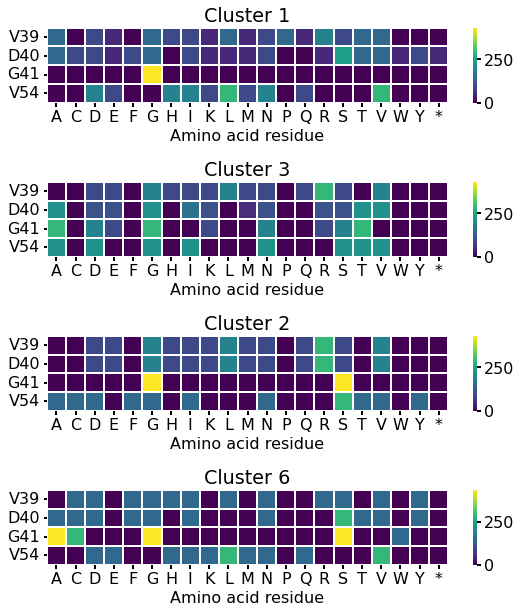

In [89]:
labels = ['V39', 'D40', 'G41', 'V54']
#labels = ['Y182', 'V183', 'F184', 'S186']
plt.figure(figsize = (8, 2.2*len(templates)))

for i in range(len(templates)):

    data = final_AA_encodings[i,:,0].reshape((4,21))
    plt.subplot(len(templates),1,i+1)
    plt.title('Cluster ' + str(indices[i]))
    sns.heatmap(data, vmin = 0, vmax = 1728/4, yticklabels=labels, xticklabels=ALL_AAS, linewidths=2, cmap = 'viridis')
    plt.xlabel('Amino acid residue')

plt.tight_layout()
#plt.savefig('AAs0.jpg', dpi=500)

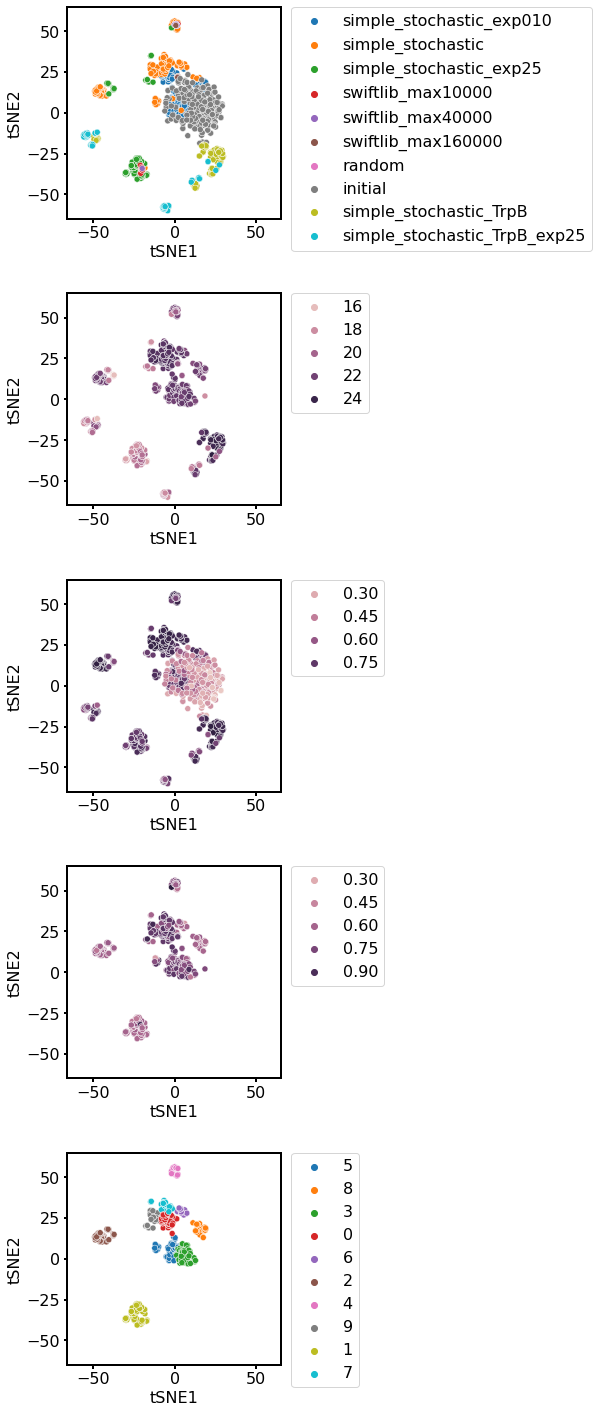

In [105]:
font = {'family' : 'arial',
        'size'   : 16}
mpl.rc('font', **font)
mpl.rc('lines', linewidth=2)
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2

plt.figure(figsize=(30, 20))
columns = ['descriptor', 'Weighted Full exp1','Weighted Simple exp1', 'Boosting Median Max', 'cluster']
for i, column in enumerate(columns):
    plt.subplot(len(columns), 1, i+1)
    sns.scatterplot(data=df, x = 'tSNE1', y = 'tSNE2', hue=column)#, hue_order=order)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    plt.xlim(-66, 65)
    plt.ylim(-65, 65)

plt.tight_layout()

In [90]:
top_df = df.sort_values('Weighted Full exp1',ascending = False).groupby('descriptor').head(10)
top_df

,Unnamed: 0,Template1,Library Size,AA Library Size,Weighted Simple,Weighted Simple exp1,frac_unique,frac_top25,frac_top5,Sampled Median Mean,Sampled Median Max,Weighted Full,Unweighted Full,Weighted Full exp1,Boosting Median Max,Boosting Median Mean,descriptor,tSNE1,tSNE2,cluster
27,50.0,NNYDTRDTSNNC,18432,4500,0.884389,0.879194,0.944922,0.944063,0.408802,NaN,NaN,24.512205,36.426686,24.512205,NaN,NaN,simple_stochastic_TrpB,26.441680,-29.643932,NaN
162,130.0,NHCVTSDTSNNT,6912,3600,0.881908,0.881908,0.936354,0.935990,0.454115,NaN,NaN,24.458369,36.003861,24.458369,NaN,NaN,simple_stochastic_TrpB,26.465328,-30.370220,NaN
23,15.0,NNCVTKDTDNNT,13824,4500,0.885004,0.879588,0.941146,0.940312,0.441250,NaN,NaN,24.432251,36.168440,24.432251,NaN,NaN,simple_stochastic_TrpB,25.680801,-28.875890,NaN
45,14.0,NNTVTKNTCNNT,6144,3600,0.883403,0.877633,0.938385,0.937656,0.452370,NaN,NaN,24.418704,36.165644,24.418704,NaN,NaN,simple_stochastic_TrpB,23.039488,-26.180010,NaN
60,143.0,NNCVTDDTSNNY,27648,4500,0.884628,0.879276,0.943490,0.942786,0.413802,NaN,NaN,24.408533,36.224716,24.408533,NaN,NaN,simple_stochastic_TrpB,26.339016,-29.435770,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,60.0,MNRRBMBMNSYW,36864,2016,0.402807,0.402807,0.804323,0.304740,0.077995,0.008247,0.500686,NaN,NaN,NaN,NaN,NaN,initial,10.487106,13.320803,NaN
6,193.0,MBRKYNRBRSRV,27648,1260,0.383111,0.383111,0.789505,0.189766,0.072578,0.005971,0.405507,NaN,NaN,NaN,NaN,NaN,initial,25.191570,1.354109,NaN
7,70.0,MBNKWDWKNNDR,110592,4851,0.310089,0.310089,0.632448,0.167917,0.028854,0.004005,0.354360,NaN,NaN,NaN,NaN,NaN,initial,20.399680,1.925508,NaN
8,125.0,MYRBYNRVYSMR,18432,720,0.360945,0.360945,0.749531,0.238958,0.098385,0.011917,0.601903,NaN,NaN,NaN,NaN,NaN,initial,3.422770,11.260295,NaN


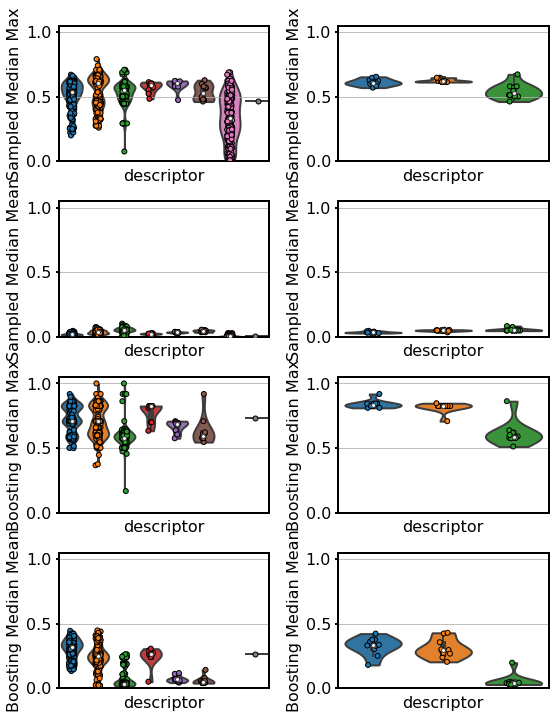

In [140]:
plt.figure(figsize=(8, 10))

ynames = ['Sampled Median Max', 'Sampled Median Mean', 'Boosting Median Max', 'Boosting Median Mean']

for j, yname in enumerate(ynames):

    plt.subplot(4, 2, 2*j + 1)
    sns.stripplot(data=df, x='descriptor', y=yname,linewidth=1,edgecolor='black', order=order, jitter=True, dodge=True)
    sns.violinplot(data=df, x='descriptor', y=yname, order= order, scale='width', cut=0)
    plt.grid(axis='y')
    plt.xticks([])
    plt.ylim([0, 1.05])

    plt.subplot(4, 2, 2*j + 2)
    sns.stripplot(data=top_df, x='descriptor', y=yname,linewidth=1,edgecolor='black', order=order, dodge=True)
    sns.violinplot(data=top_df, x='descriptor', y=yname, order=order[:3],scale='width', cut=0)
    plt.grid(axis='y')
    plt.xticks([])
    plt.ylim([0, 1.05])

plt.tight_layout()

In [23]:
df[df['Unweighted Full'] > 36]

,Template1,Library Size,AA Library Size,Weighted Simple,Weighted Simple exp1,frac_unique,frac_top25,frac_top5,Sampled Median Mean,Sampled Median Max,Weighted Full,Unweighted Full,Boosting Median Max,Boosting Median Mean
25,VNSNNSKSCNNS,98304.0,28224,0.671738,0.671666,0.928724,0.60362,0.235755,0.020818,0.573387,21.343385,36.966438,0.825004,0.292321


0.7017967945598875
0.24893869431477517


Text(0.5, 0, 'Optimized Libraries')

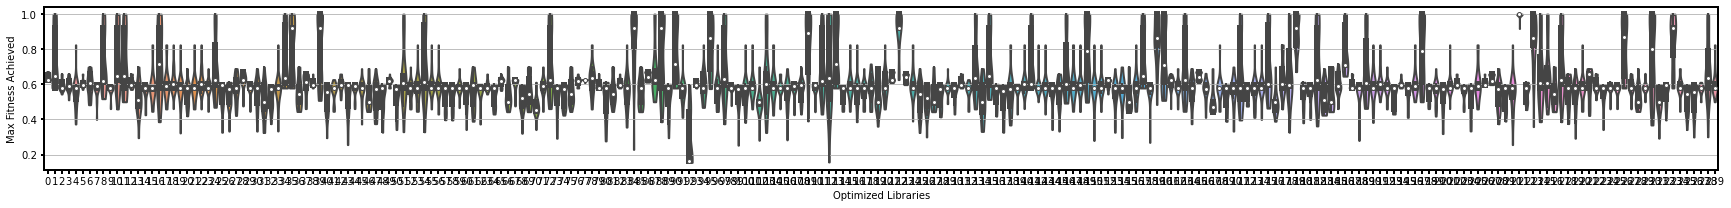

In [34]:
#MLDE violin plots
print(np.mean(df['Boosting Median Max']))
print(np.mean(df['Boosting Median Mean']))

plt.figure(figsize = (30, 3))
ax = sns.violinplot(data=maxes2, scale='width', cut=0)
#ax.set_xticklabels(['Random', 'Top 32000', 'Top 16000', 'Top 8000', 'Top 4000'])
#ax.set_xticklabels(['288', '336', '360', '372', '384'])
plt.grid(axis = 'y')
plt.ylabel('Max Fitness Achieved')
plt.xlabel('Optimized Libraries')
#plt.savefig('all_mix2_violin.jpg', dpi=500)

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


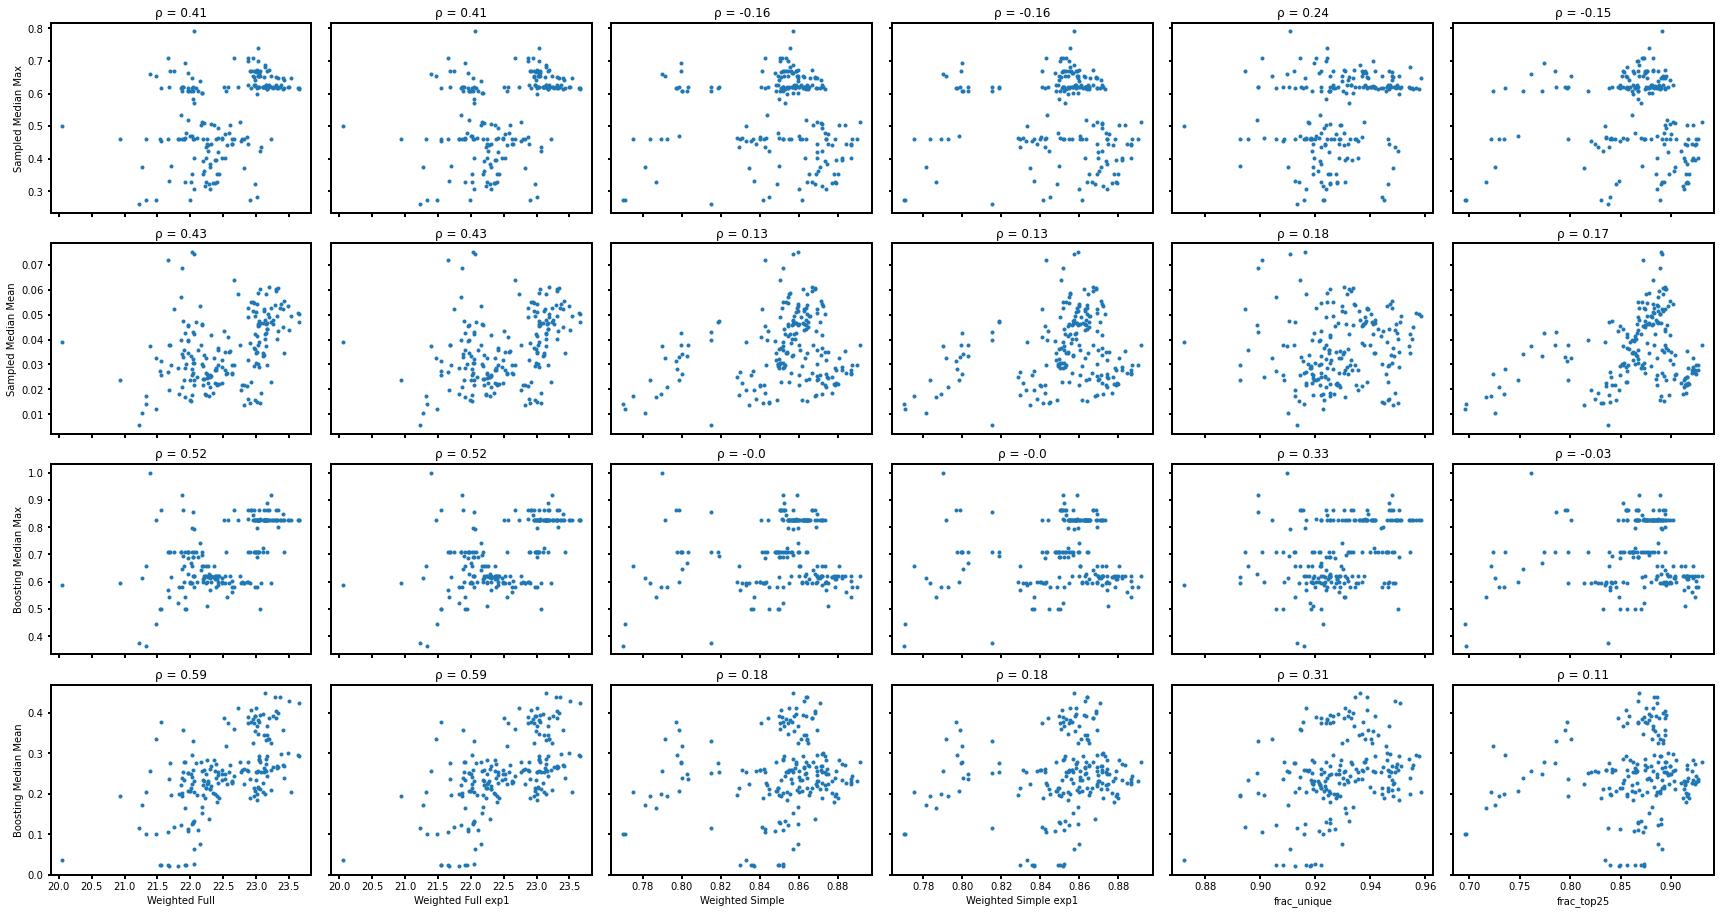

In [3]:
#correlation plots
df_subset = df[df['descriptor'] == 'simple_stochastic']

xnames = ['Weighted Full', 'Weighted Full exp1', 'Weighted Simple', 'Weighted Simple exp1', 'frac_unique', 'frac_top25']
ynames = ['Sampled Median Max', 'Sampled Median Mean', 'Boosting Median Max', 'Boosting Median Mean']

fig, axs = plt.subplots(len(ynames), len(xnames), figsize = (4*len(xnames), 3.2*len(ynames)))

for j, yname in enumerate(ynames):
    for i, xname in enumerate(xnames):

        x = df_subset[xname].values
        y = df_subset[yname].values

        # order = coverages.argsort()
        # ranks1 = order.argsort()
        plt.subplot(len(ynames),len(xnames), len(xnames)*(j) + i +1)
        plt.plot(x, y, '.')
        #plt.plot(x_random/384, y_random, 'k-')
        #plt.plot(1, y_triad_4000, 'r.')

        if j == len(ynames) - 1:
            plt.xlabel(xname)
        else:
            axs[j, i].set_xticklabels([])

        if i == 0:
            plt.ylabel(yname)
        else:
            axs[j, i].set_yticklabels([])
            
        plt.title('\u03C1 = ' + str(round(spearmanr(x, y)[0],2)))

plt.tight_layout()

In [3]:
fitness_df = pd.read_csv('/home/jyang4/repos/StARDUST/data/GB1/fitness.csv')

#to calculate coverage for a few library sizes
with open('/home/jyang4/repos/StARDUST/dclo/configs/coverage_DEFAULT.json', 'r') as f:
    config = json.load(f)

x_random = np.array([240, 384])
y_random = []
y_triad_4000 = []

for n in x_random:
    oracle = Oracle(config['data_config'], config['opt_config'], verbose = True)
    samples = fitness_df['Combo'].sample(n=n, random_state=42).values
    scores, unweighted_scores, raw_scores, counts, diversity, _ = oracle.aas2zs(samples)
    y_random.append(unweighted_scores)
    print(scores)
    print(unweighted_scores)
    print(raw_scores)

subset_df = fitness_df.sort_values(by='Triad-FixedBb-dG', ascending = False)[:4000]
samples = subset_df['Combo'].sample(n=384, random_state=42).values
scores, unweighted_scores, raw_scores, counts, diversity, _ = oracle.aas2zs(samples)
y_triad_4000.append(unweighted_scores)
print(scores)
print(unweighted_scores)
print(raw_scores)
    

0.9169032240906435
25.98055943117518
0.28561386718750015
1.4456167526093486
40.78156010658663
0.47262626953125
6.014256749661077
37.7897223688643
0.978252571614584


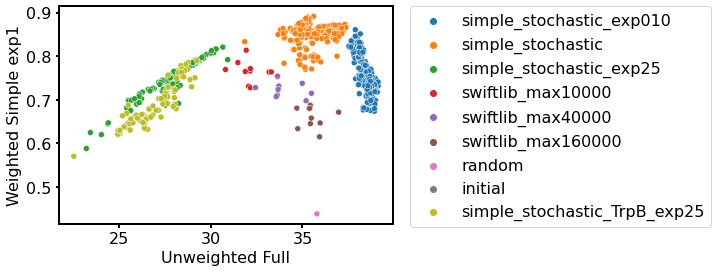

In [151]:
df_subset = df[~df['descriptor'].isin(['simple_stochastic_TrpB', 'simple_stochastic_TrpB_ep25'])]
sns.scatterplot(data=df_subset, x = 'Unweighted Full', y = 'Weighted Simple exp1', hue='descriptor')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

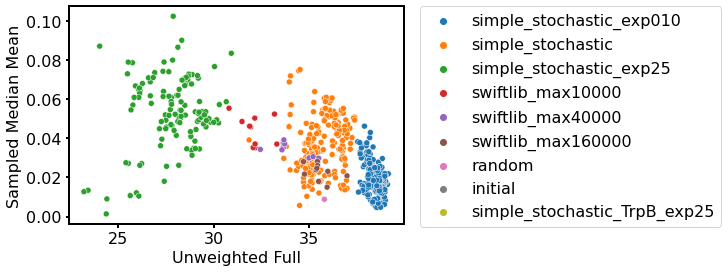

In [147]:
df_subset = df[~df['descriptor'].isin(['simple_stochastic_TrpB', 'simple_stochastic_TrpB_ep25'])]
sns.scatterplot(data=df_subset, x = 'Unweighted Full', y = 'Sampled Median Mean', hue='descriptor')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

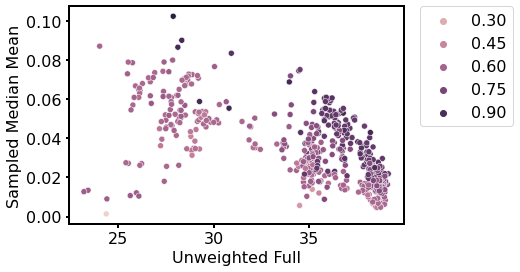

In [148]:
sns.scatterplot(data=df_subset, x = 'Unweighted Full', y = 'Sampled Median Mean', hue='Boosting Median Max')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

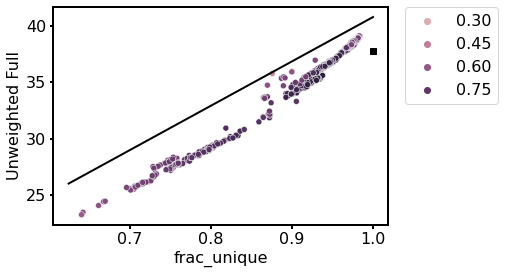

In [149]:
plt.plot([240/384, 384/384], [26, 40.8], '-k' )

#triad from top 4000, just one point, should sample a few to get statistics
plt.plot([384/384], [37.8], 'sk' )

df_subset = df[~df['descriptor'].isin(['simple_stochastic_TrpB', 'simple_stochastic_TrpB_ep25'])]
sns.scatterplot(data=df_subset, x = 'frac_unique', y = 'Unweighted Full', hue='Weighted Simple exp1')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

Weighted full is generally a more robust predictor, but weighted simple is just as good when there is not enough exploitation occuring. If there is too much exploitation, weighted full is better because it balances out exploration.